<a href="https://colab.research.google.com/github/potulabe/symphonypy/blob/main/benchmarking/Benchmarking_symphony_PBMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Symphony R vs symphonypy

To demonstrate equivalence of symphony and symphonypy, we will get one of the symphony's prebuilt references from [zenodo](https://zenodo.org/record/5090425#.Y8w0EHZBxPZ) and map another dataset on it via symphony and via symphonypy.  
To compare the results we will count distances between resulting cell's embeddings and estimate the accuracy of cell type prediction.

In [1]:
%%capture
!pip install symphonypy rpy2==3.5.1  # currently have to downgrade rpy2, otherwise it doesn't work in google colab

In [2]:
import os
import sys

import anndata as ad
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import symphonypy as sp

from scipy.sparse import csr_matrix
from scipy.stats import ttest_ind
from tqdm.notebook import tqdm

sc.set_figure_params(dpi=150)

In [3]:
%load_ext rpy2.ipython
import rpy2
rpy2.rinterface_lib.callbacks.consolewrite_warnerror = lambda x: print(x, end="")

## Data loading

### Load Symphony's precomputed PBMC reference

In [4]:
!curl -o pbmcs_10x_reference.rds "https://zenodo.org/record/5090425/files/pbmcs_10x_reference.rds"
!curl -o pbmcs_10x_uwot_model "https://zenodo.org/record/5090425/files/pbmcs_10x_uwot_model"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 20.4M  100 20.4M    0     0   545k      0  0:00:38  0:00:38 --:--:--  561k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 15.3M  100 15.3M    0     0   542k      0  0:00:28  0:00:28 --:--:--  578k


In [4]:
%%R
ref_pbmcs = readRDS('pbmcs_10x_reference.rds')
ref_pbmcs$save_uwot_path <- "pbmcs_10x_uwot_model"

In [5]:
%%R -o meta_data,vargenes,loadings,R,Z_orig,Z_corr,centroids,Nr,C,n_neighbors,centroids_pc

meta_data <- ref_pbmcs$meta_data
vargenes <- ref_pbmcs$vargenes
loadings <- ref_pbmcs$loadings
R <- ref_pbmcs$R
Z_orig <- ref_pbmcs$Z_orig
Z_corr <- ref_pbmcs$Z_corr
centroids <- ref_pbmcs$centroids
centroids_pc <- ref_pbmcs$centroids_pc
Nr <- ref_pbmcs$cache[[1]]
C <- ref_pbmcs$cache[[2]]
n_neighbors <- ref_pbmcs$umap$n_neighbors

### Create python anndata reference object from the Symphony's precomputed reference

In [6]:
K = C.shape[0]
meta_data.set_index("cell_id", inplace=True)
vargenes.set_index("symbol", inplace=True)

adata_reference = ad.AnnData(csr_matrix((meta_data.shape[0], vargenes.shape[0])))

adata_reference.obs_names = meta_data.index
adata_reference.var_names = vargenes.index
adata_reference.obs = meta_data

# HVG, mean, std
adata_reference.var["highly_variable"] = True
adata_reference.var["mean"] = vargenes["mean"]
adata_reference.var["std"] = vargenes.stddev

# PCA
adata_reference.obsm["X_pca"] = Z_orig.T
adata_reference.obsm["X_pca_harmony"] = Z_corr.T
adata_reference.varm["PCs"] = loadings

# harmony obj
adata_reference.uns["harmony"] = {
    "Nr": Nr.squeeze(1),
    "C": C,
    "Y": centroids.T,
    "centroids_pc": centroids_pc.T,
    "K": K,
    "ref_basis_loadings": "PCs",
    "ref_basis_adjusted": "X_pca_harmony"
}

<ipython-input-6-155729677d40>:5: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_reference = ad.AnnData(csr_matrix((meta_data.shape[0], vargenes.shape[0])))


In [7]:
# UMAP
n_comps = Z_orig.shape[0]
n_neighbors = int(n_neighbors[0])

sc.pp.neighbors(
    adata_reference, n_pcs=n_comps, n_neighbors=n_neighbors, use_rep="X_pca_harmony"
)

sc.tl.umap(adata_reference)

### Load query PBMC dataset

In [8]:
adata_query = sc.datasets.pbmc3k()

  0%|          | 0.00/5.58M [00:00<?, ?B/s]

In [9]:
sc.pp.normalize_total(adata_query)
sc.pp.log1p(adata_query)

In [10]:
adata_query

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'
    uns: 'log1p'

## Symphony (R)

### Map query to reference

load query data to R:

In [11]:
query_exp = adata_query.X.A.T
query_metadata = adata_query.obs
gene_names = adata_query.var_names

In [12]:
%%R -i query_exp,query_metadata,gene_names
rownames(query_exp) <- gene_names

run mapQuery (with Umap mapping):

In [15]:
%%capture
%%R
install.packages("symphony")

In [16]:
%%time
%%R
library(symphony)
query = symphony::mapQuery(
                 query_exp,             # query gene expression (genes x cells)
                 query_metadata,        # query metadata (cells x attributes)
                 ref_pbmcs,             # Symphony reference object
                 do_normalize = FALSE,  # perform log(CP10k+1) normalization on query
                 do_umap = TRUE,
                 )

Scaling and synchronizing query gene expression
Found 1911 out of 2357 reference variable genes in query dataset
Project query cells using reference gene loadings
Clustering query cells to reference centroids
Correcting query batch effects
UMAP
All done!
CPU times: user 4.41 s, sys: 169 ms, total: 4.58 s
Wall time: 4.52 s


In [17]:
%%R -o X_pca_harmony_R

X_pca_harmony_R <- query$Z

save resulted embeddings to adata_query:

In [18]:
adata_query.obsm["X_pca_harmony_R"] = X_pca_harmony_R.T

### Predict cell types via kNN

In [19]:
%%time
%%R -i n_neighbors -o knn_pred_cell_type,knn_pred_cell_type_broad

knn_pred_cell_type = as.character(
    class::knn(
        t(ref_pbmcs$Z_corr), t(query$Z), ref_pbmcs$meta_data$cell_type, k = n_neighbors, prob = FALSE
        )
    )
knn_pred_cell_type_broad = as.character(
    class::knn(
        t(ref_pbmcs$Z_corr), t(query$Z), ref_pbmcs$meta_data$cell_type_broad, k = n_neighbors, prob = FALSE
    )
)

CPU times: user 3.58 s, sys: 11.4 ms, total: 3.59 s
Wall time: 3.78 s


save predicted cell types to adata_query:

In [20]:
adata_query.obs["cell_type.R"] = knn_pred_cell_type_broad
adata_query.obs["cell_subtype.R"] = knn_pred_cell_type

## Symphonypy

map query to reference:

In [21]:
%%time
sp.tl.map_embedding(
    adata_query,
    adata_reference,
    adjusted_basis_query="X_pca_harmony",
    query_basis_ref="X_pca_reference"
)
# -> adata_query.obsm["X_pca_harmony"]

CPU times: user 2.83 s, sys: 166 ms, total: 2.99 s
Wall time: 3.05 s


map Umap coords:

In [22]:
%%time
sp.tl.ingest(adata_query=adata_query, adata_ref=adata_reference, embedding_method="umap")
# -> adata_query.obsm["X_umap"]

CPU times: user 35.8 s, sys: 547 ms, total: 36.3 s
Wall time: 36.8 s


predict cell types via kNN:

In [23]:
%%time
labels = ["cell_type", "cell_type_broad"]  # any columns from adata_ref.obs
transferred_labels = ["cell_subtype.py", "cell_type.py"]

# transfer labels via scipy kNN
sp.tl.transfer_labels_kNN(
    adata_query,
    adata_reference,
    labels,
    # kNN args
    n_neighbors,
    query_labels=transferred_labels,
    ref_basis="X_pca_harmony",
    query_basis="X_pca_harmony",
    # kNN kwargs
    weights="distance",
)
# -> adata_query.obs[transferred_labels]

CPU times: user 1.11 s, sys: 75.3 ms, total: 1.18 s
Wall time: 1.01 s


## Distances between symphonypy and symphony R results

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("ticks")

count L2 distances:

In [25]:
distances = (((adata_query.obsm["X_pca_harmony_R"] - adata_query.obsm["X_pca_harmony"])**2).sum(axis=1))**0.5

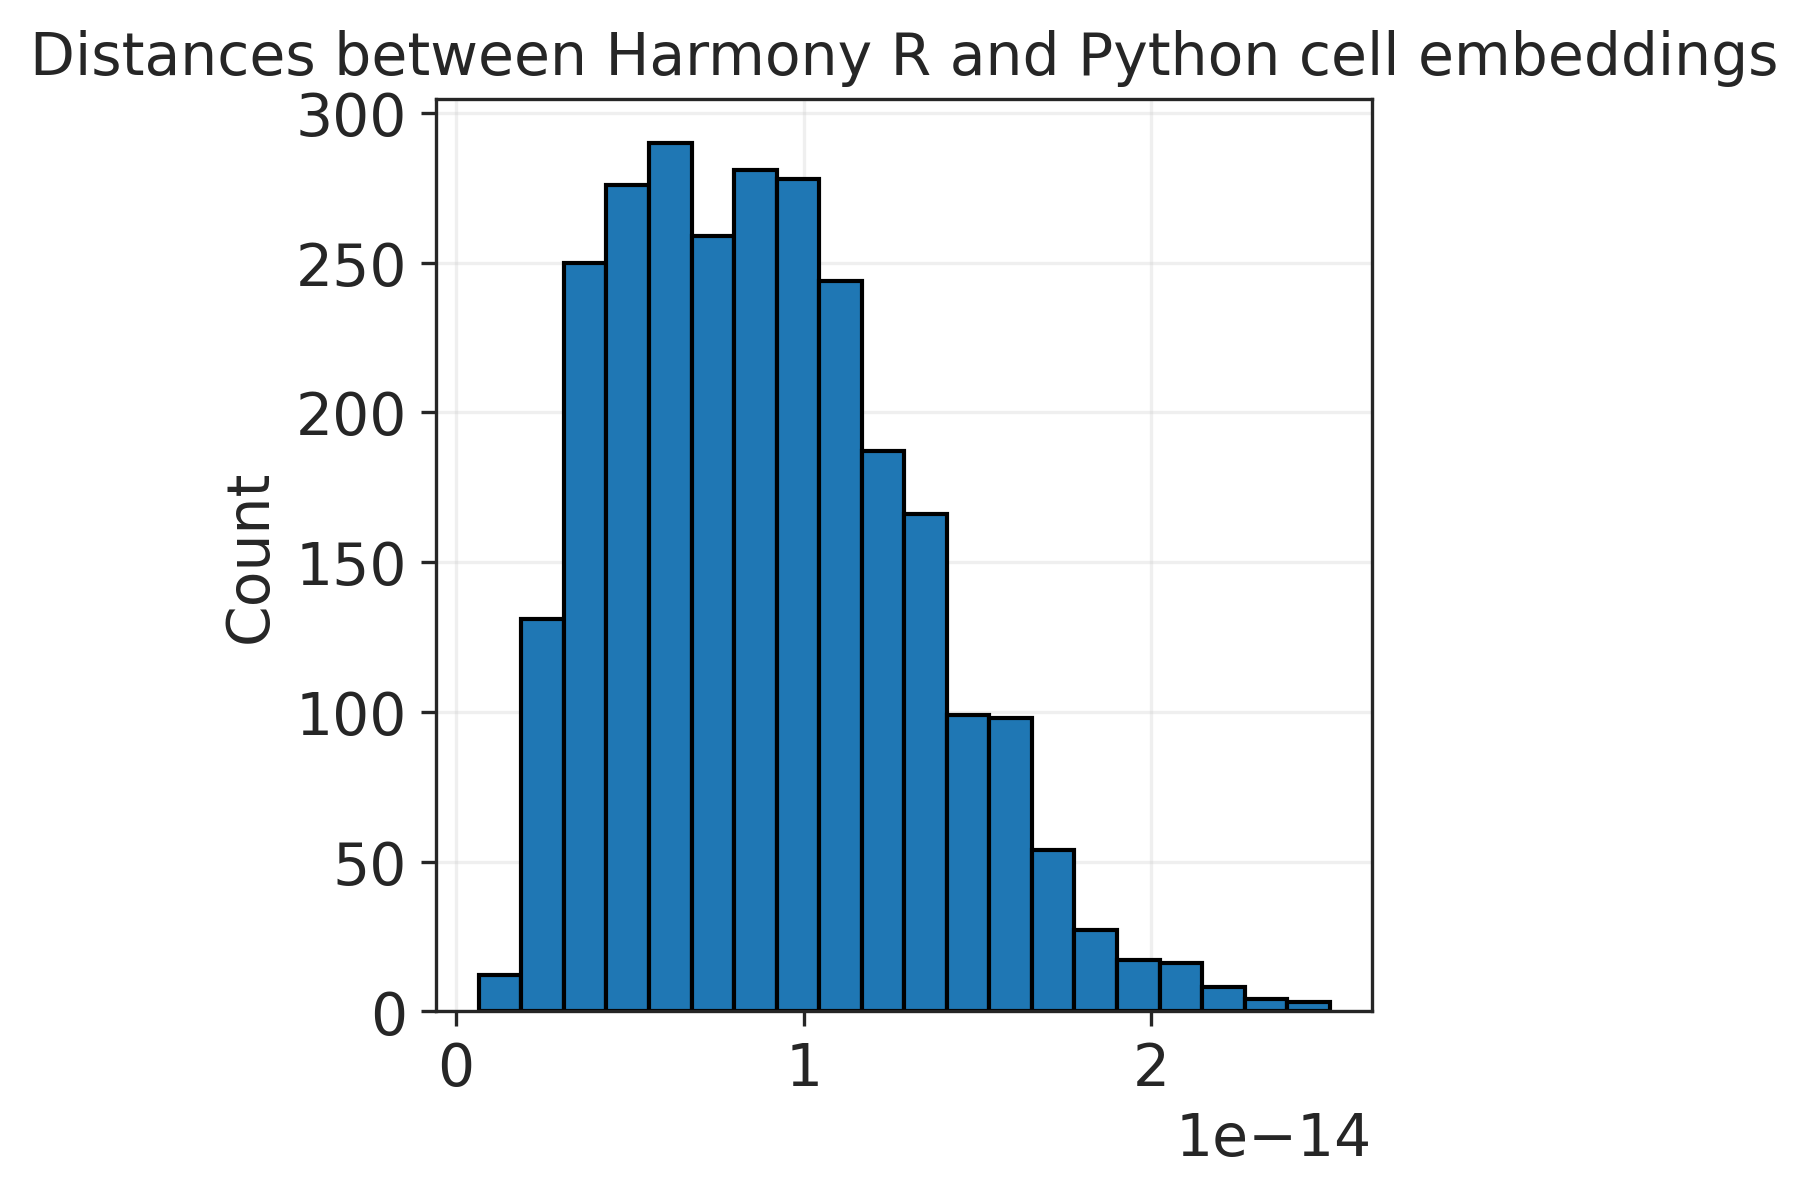

In [26]:
fig, ax = plt.subplots(figsize=(4, 4))
sns.histplot(distances, ax=ax, discrete=False, linewidth=1, edgecolor="black", alpha=1, legend=False, bins=20)
ax.set_title("Distances between Harmony R and Python cell embeddings")
ax.grid(alpha=0.3)

## Cell type prediction accuracy

In [30]:
conf_matrix_R_py = sc.metrics.confusion_matrix(adata_query.obs["cell_subtype.py"], adata_query.obs["cell_subtype.R"])

Text(0.5, 1.0, 'R vs Python predicted cell type')

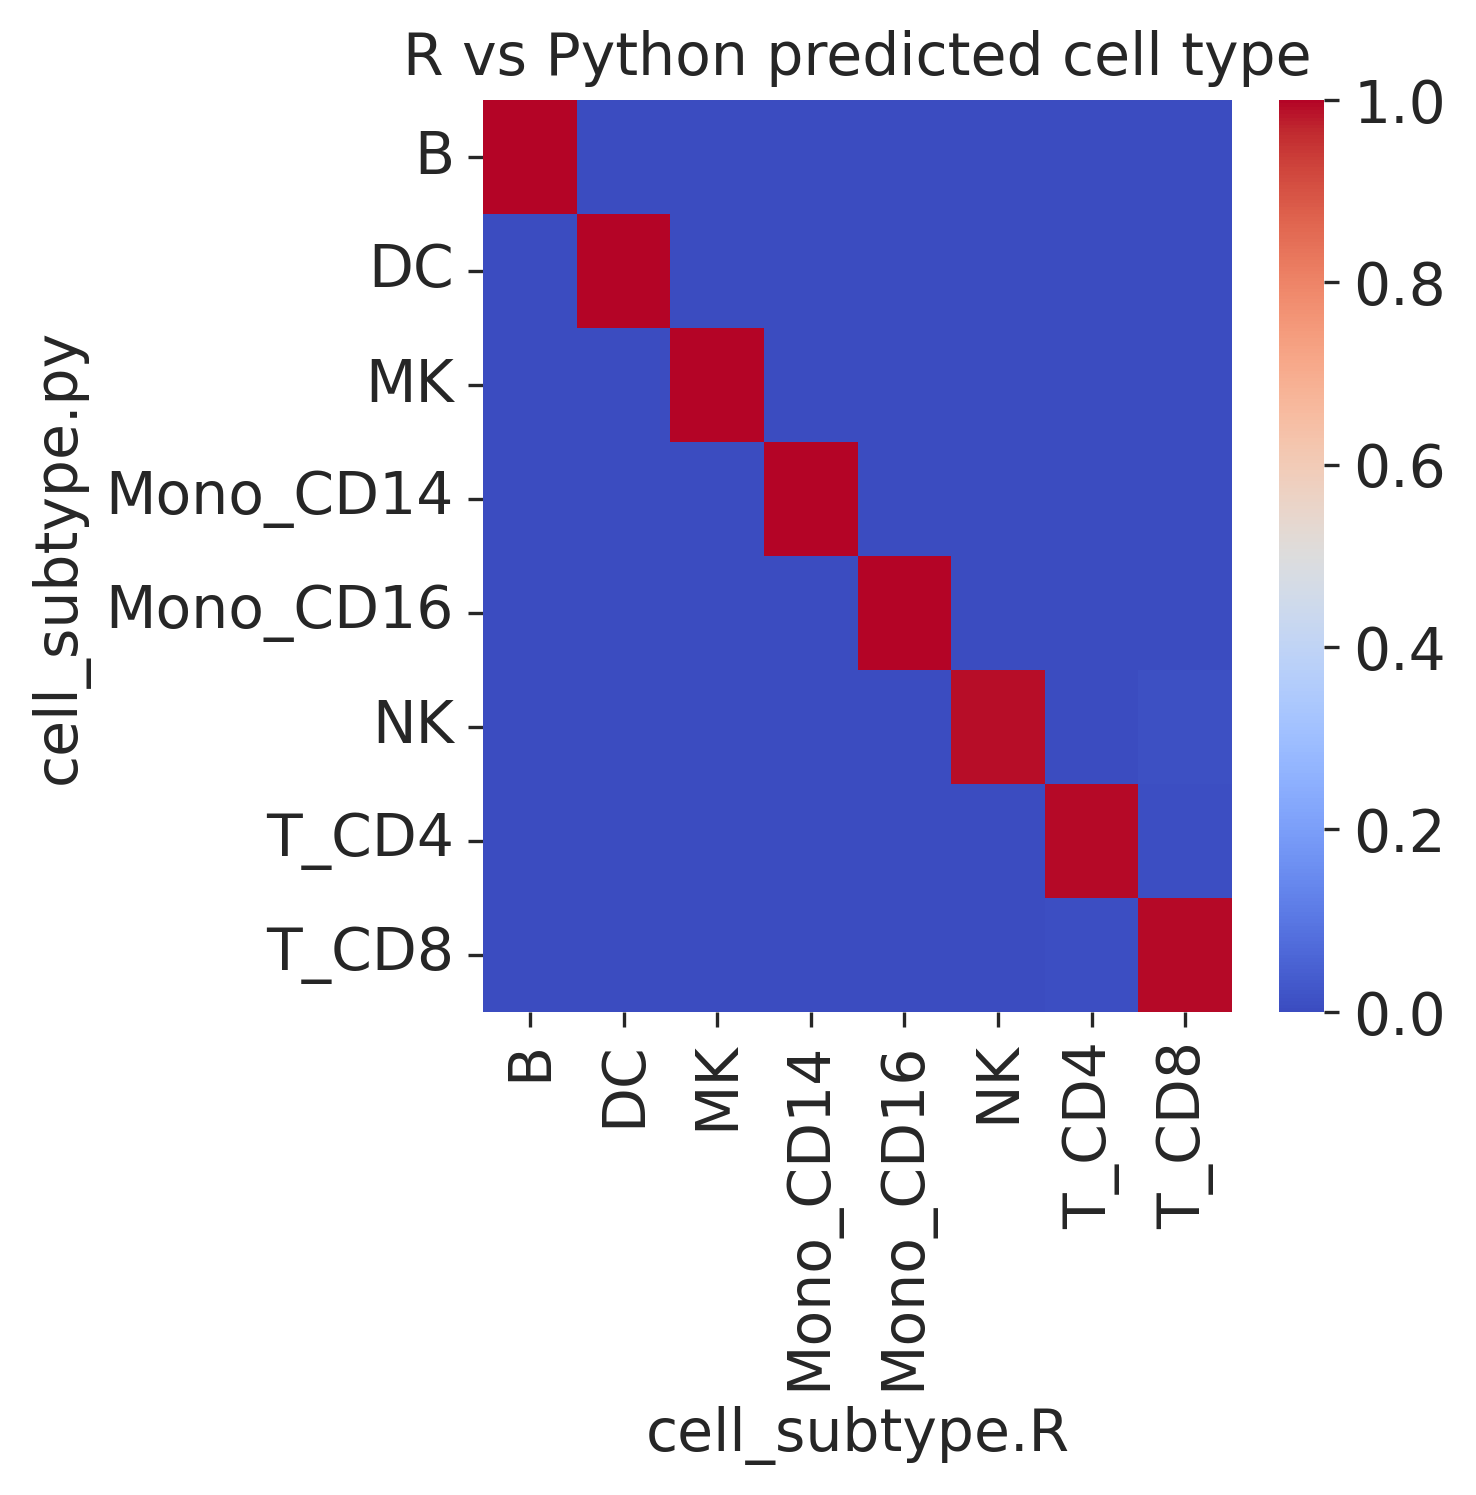

In [31]:
hrpy = sns.heatmap(conf_matrix_R_py, cmap="coolwarm")
hrpy.set_title(f"R vs Python predicted cell type")